# Biot's equations: Convergence Test

* Author: Jhabriel Varela
* E-mail: jhabriel.varela@uib.no
* Date: 03.04.2019
* Institution: PMG - UiB - Norway

## Description of the problem

In this noteboook, we perform a numerical convergence test (in space) of the Biot's equations. Let $\Omega$ be a regular domain with boundary $\partial \Omega$. The Biot equations formulation read:
$$
\begin{align}
\nabla \cdot \frac{1}{2}D(\nabla \mathbf{u} + \nabla \mathbf{u}^T) - \alpha \nabla p &= F, \\
\frac{\partial}{\partial t}(\beta p + \alpha \nabla \cdot \mathbf{u}) - \nabla \cdot K \nabla p &= f.
\end{align}
$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$\begin{align}
    p = p_b, \qquad & \qquad - K \nabla p \cdot \mathbf{n} = v_b, \\
    \mathbf{u} = \mathbf{u}_b,  \qquad & \qquad \frac{1}{2}D(\nabla \mathbf{u} + \nabla \mathbf{u}^T) \cdot \mathbf{n} = t_b.
\end{align}$$

In the above, the unknowns are the displacements $\mathbf{u}$ and the pressure $p$. The parameters are the scalar and vector source/sink terms $F$ and $f$, the permeability matrix $K$, the stiffness matrix $D$ (which depends on the two Lamé parameters $\lambda$ and $\mu$), the Biot coefficient $\alpha$, the storativiy coefficient $\beta$ and the density $\rho$. $p_b$ is the pressure at the boundary (Dirichlet condition), $v_p$ is the flux at the boundary (Neumann condition), $\mathbf{u}_b$ is the displacement at the boundary (Dirichlet condition) and $t_b$ is the traction at the boundary (Neumann condition).

To show the convergence of the MPFA/MPSA method, we employ a known "manufactured" solution of the type:

$$ \mathbf{u}(x,y) =  \begin{pmatrix} x(1-x) + \sin(2\pi y) \\ \sin(2\pi x) \sin(2 \pi y) \end{pmatrix}, \\
p(x,y) =  x(1-x) + \sin(2\pi y).$$

These solutions (conveniently) satisfy zero Dirichlet boundary conditions for both, the mechanic and flow problems and hold for the first time step. Hence, the problem is driven by internal source terms.

Computing the left hand side of the momentum and mass balance equations with $\alpha = \mu = \lambda = K = 1$ and $\beta = 0$, we get the following right hand sides:

$$ F(x,y) = \begin{pmatrix} 
6\sin(2\pi y) - x\sin(2\pi y) - \sin(2\pi x2)(x - 1) - 8 \pi^2 \cos(2 \pi x)\cos(2 \pi y) - 4 x \pi^2 \sin(2 \pi y)(x - 1) \\
4 \pi \cos(2 \pi y)(x - 1) + 16 \pi^2 \sin(2 \pi x) \sin(2 \pi y) + 4x \pi \cos(2 \pi y) - 2x\pi\cos(2\pi y)(x - 1)
\end{pmatrix}, \\
f(x,y) = \tau(2\sin(2\pi y) - 4x\pi^2\sin(2\pi y)(x - 1)) - x\sin(2 \pi y) - \sin(2 \pi y)(x - 1) + 2\pi\cos(2\pi y)\sin(2\pi x),$$

where $\tau$ is the time step, which in this case was set to $1$. We solve the set of equations for different values of step size on an unit-square using a cartesian structured grid.

We are interested in analyzing the rate of convergence of the primary variables, $\mathbf{u}$ and $p$. For that purpose, we define the following errors using $L^2$-type norms as in [[1](#ref)]:

$$
\epsilon_p = \frac{||\tilde{p} - p||_{L^2}}{|| p ||_{L^2}}, \qquad
\epsilon_{\mathbf{u}} = \frac{||\tilde{\mathbf{u}} - \mathbf{u} ||_{L^2}}{||\mathbf{u}||_{L^2} }, \qquad
\epsilon_{p,\mathbf{u}} = \epsilon_p + \tau \epsilon_{\mathbf{u}},
$$

where $\tilde{p}$ and $\tilde{\mathbf{u}}$ are the exact solutions for the problem. The norm $\epsilon_{p,\mathbf{u}}$ is the primary error, a measure of the total error of the coupled problem.

## Importing modules

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from biot_convergence import convergence_in_space
np.set_printoptions(precision=4, suppress = True)

## Functions

In [2]:
# Defining a straight line (for fitting purposes)
def straight_line(x,a,b):
    return a + b*x

# Getting the coordinates of the fitted line
def get_fitted_line_coor(step_size,popt):
    x_fit = np.array(([np.min(np.log(step_size)),np.max(np.log(step_size))]))
    y_fit = straight_line(x_fit,popt[0][0],popt[0][1])
    return x_fit, y_fit

# Getting r_squared (to check linearity of the convergence rate)
def get_r_squared(epsilon,step_size,popt):
    res = np.log(epsilon) - straight_line(np.log(step_size),popt[0][0],popt[0][1])
    ss_res = np.sum(res**2)
    ss_tot = np.sum((np.log(epsilon)-np.mean(np.log(epsilon)))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

## Convergence analysis

The convergence analysis is perfomed for the three errors introduce above. Generally, for a sufficiently small $h$ we can write

$$
    \epsilon \leq C h^p + \mathcal{O}(h^{p+1}),
$$

where $C$ is a constant independent of $h$ and $\tau$. If we take the logarithm to both sides of the equation and use the worst case scenario (the equatility) we have:

$$
    \log(\epsilon) \approx \log(C) + p \log(h). 
$$

By fitting a line and determining the slope of a log-log plot of the error as a function of the step size, we can determine the order of convergence of the numerical approximation.

### Computing the errors for different mesh sizes

In [3]:
# Number of cells and step sizes
number_of_cells = np.array([8,16,32,64,128,256])
h  = 1/number_of_cells 

# Initializing errors
epsilon_p = np.zeros(len(h))
epsilon_u = np.zeros(len(h))
epsilon_pu = np.zeros(len(h))

# Loop through number_of_cells
for i in range(len(number_of_cells)):
    epsilon_p[i],epsilon_u[i],epsilon_pu[i] = convergence_in_space(number_of_cells[i])

Solving with mesh grid [8,8]
Iter: 2 	 Error: 8.23578381468461e-15 
Solving with mesh grid [16,16]
Iter: 2 	 Error: 1.8285972680898285e-14 
Solving with mesh grid [32,32]
Iter: 2 	 Error: 3.824241916190777e-14 
Solving with mesh grid [64,64]
Iter: 2 	 Error: 9.110945155720319e-14 
Solving with mesh grid [128,128]
Iter: 2 	 Error: 1.9218918316215614e-13 
Solving with mesh grid [256,256]
Iter: 2 	 Error: 3.233739442684174e-13 


### Plotting convergence rate

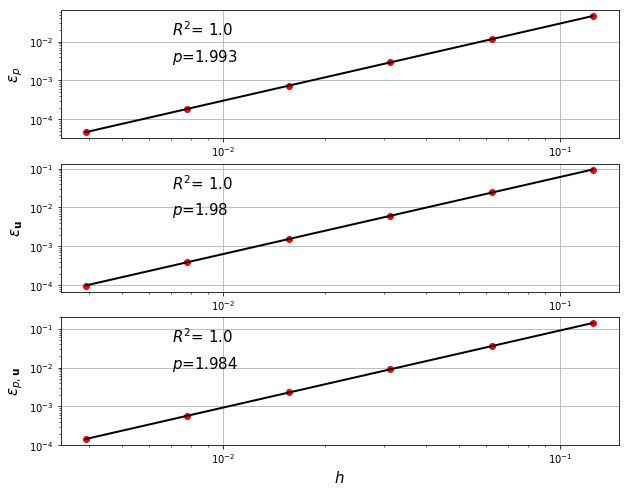

In [4]:
# Obtaining line parameters
popt_p   = opt.curve_fit(straight_line,np.log(h),np.log(epsilon_p))
popt_u   = opt.curve_fit(straight_line,np.log(h),np.log(epsilon_u))
popt_pu  = opt.curve_fit(straight_line,np.log(h),np.log(epsilon_pu))

# Getting coordinates of fitted lines
x_fit_p,y_fit_p = get_fitted_line_coor(h,popt_p) 
x_fit_u,y_fit_u = get_fitted_line_coor(h,popt_u) 
x_fit_pu,y_fit_pu = get_fitted_line_coor(h,popt_pu)

# Determining R^2
r_squared_p = get_r_squared(epsilon_p,h,popt_p)
r_squared_u = get_r_squared(epsilon_u,h,popt_u)
r_squared_pu = get_r_squared(epsilon_pu,h,popt_pu)

# Creating the figure object and its subplots
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

# Plotting numerical data and fitted line
ax1.loglog(h,epsilon_p,'or',linewidth=2,label = 'Numerical data')
ax1.loglog(np.exp(x_fit_p),np.exp(y_fit_p),'-k',linewidth=2,label='Fitted line')

ax2.loglog(h,epsilon_u,'or',linewidth=2,label = 'Numerical data')
ax2.loglog(np.exp(x_fit_u),np.exp(y_fit_u),'-k',linewidth=2,label='Fitted line')

ax3.loglog(h,epsilon_pu,'or',linewidth=2,label = 'Numerical data')
ax3.loglog(np.exp(x_fit_pu),np.exp(y_fit_pu),'-k',linewidth=2,label='Fitted line')

# Adding legend, and information
ax1.set_xlabel(r'$h$', fontsize=15)
ax1.set_ylabel(r'$\epsilon_p$',fontsize=15)
ax1.text(0.2,0.8,r'$R^2$= {:.4}'.format(r_squared_p),size=15,transform=ax1.transAxes)
ax1.text(0.2,0.6,r'$p$={:.4}'.format(popt_p[0][1]),size=15,transform=ax1.transAxes)
ax1.grid(True)

ax2.set_xlabel(r'$h$', fontsize=15)
ax2.set_ylabel(r'$\epsilon_\mathbf{u}$',fontsize=15)
ax2.text(0.2,0.8,r'$R^2$= {:.4}'.format(r_squared_u),size=15,transform=ax2.transAxes)
ax2.text(0.2,0.6,r'$p$={:.4}'.format(popt_u[0][1]),size=15,transform=ax2.transAxes)
ax2.grid(True)

ax3.set_xlabel(r'$h$', fontsize=15)
ax3.set_ylabel(r'$\epsilon_{p,\mathbf{u}}$',fontsize=15)
ax3.text(0.2,0.8,r'$R^2$= {:.4}'.format(r_squared_pu),size=15,transform=ax3.transAxes)
ax3.text(0.2,0.6,r'$p$={:.4}'.format(popt_pu[0][1]),size=15,transform=ax3.transAxes)
ax3.grid(True)

plt.show()

## References
<a id='ref'></a>

[1] *Nordbotten, J. M. (2016). Stable cell-centered finite volume discretization for Biot equations. SIAM Journal on Numerical Analysis, 54(2), 942-968.
ISO 690*